In [1]:
from typing import List, Dict, Tuple, Optional, Union, Any, Generator
from urllib import request
import os

from IPython.display import SVG

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.PandasTools import LoadSDF
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error
from boruta import BorutaPy
from tqdm.notebook import tqdm, trange
import optuna
import shap

In [2]:
SEED = 334

In [3]:
rdkit.rdBase.rdkitVersion

'2022.03.4'

In [4]:
url_sdf = 'http://datachemeng.wp.xdomain.jp/wp-content/uploads/2017/04/logSdataset1290_2d.sdf'
# download and create cache
dirpath_cache = os.path.abspath('./cache')
if not os.path.exists(dirpath_cache):
    os.mkdir(dirpath_cache)
fpath_sdf_cached = os.path.join(dirpath_cache, os.path.basename(url_sdf))
if not os.path.exists(fpath_sdf_cached):
    with request.urlopen(url_sdf) as response, open(fpath_sdf_cached, mode='w', encoding='utf-8') as out_file:
        data = response.read().decode('utf-8')
        out_file.write(data)

,CAS_Number,logS,ID,ROMol,CA_Number
0,60-35-5,1.58,CC(N)=O,,NaN
1,NaN,1.34,CNN,,60-34-4
2,NaN,1.22,CC(O)=O,,64-19-7
3,NaN,1.15,C1CCCN1,,123-75-1
4,NaN,1.12,NC([NH]O)=O,,127-07-1

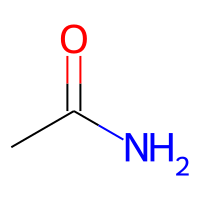
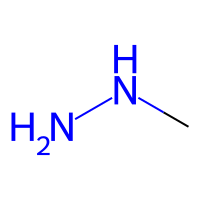
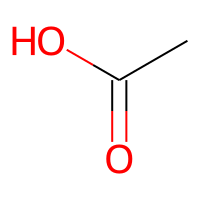
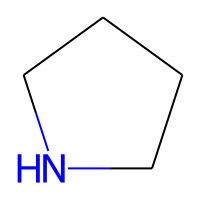
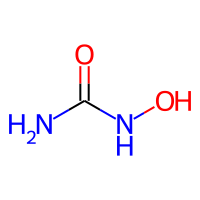

In [5]:
df:pd.DataFrame = LoadSDF(fpath_sdf_cached)
df.head()

In [6]:
target_col = 'logS'
col_smiles = 'SMILES'

SMILESに変換して重複を削除してキーにする。

,logS,ROMol
SMILES,,
Br/C=C\Br,-1.32,
BrC(Br)(Br)Br,-3.14,
BrC(Br)Br,-1.91,
BrC1CCCCC1,-2.30,
BrCBr,-1.17,

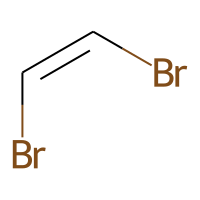
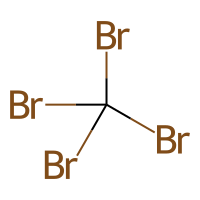
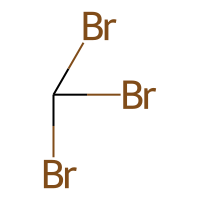
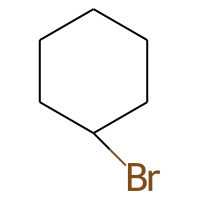
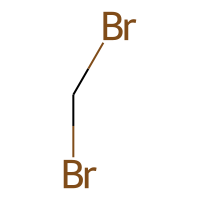

In [7]:
df[col_smiles] = df['ROMol'].apply(Chem.MolToSmiles)
df[target_col] = df[target_col].astype(float)

df_extracted = pd.concat([
    df[[col_smiles, target_col]].groupby(col_smiles).mean(),
    df[[col_smiles, 'ROMol']].groupby(col_smiles).first()
], axis=1)
df_extracted.head()

In [8]:
bitinfos:List[Dict[int,Tuple]] = []
fps:List[rdkit.DataStructs.cDataStructs.ExplicitBitVect] = []
for _mol in df_extracted['ROMol']:
    bitinfo:Dict[int,Tuple] = {}
    fp = np.array(GetMorganFingerprintAsBitVect(_mol, radius=2, nBits=1024, bitInfo=bitinfo), dtype=int)
    bitinfos.append(bitinfo)
    fps.append(fp)
X:pd.DataFrame = pd.DataFrame(np.vstack(fps), index=df_extracted.index)
X.shape

(1286, 1024)

In [9]:
y = df_extracted[target_col]
y.shape

(1286,)

In [10]:
vselector = VarianceThreshold(threshold=0.0)
vselector.fit(X, y)
X_vselected:pd.DataFrame = X.iloc[:, vselector.get_support()]
X_vselected.shape

(1286, 1012)

In [11]:
feature_selector = BorutaPy(RandomForestRegressor(random_state=SEED, n_jobs=-1), n_estimators='auto', verbose=2, perc=80, random_state=SEED, max_iter=100)
feature_selector.fit(X_vselected.values, y)
X_selected:pd.DataFrame = X_vselected.iloc[:, feature_selector.support_]
X_selected.shape

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1012
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1012
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1012
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1012
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1012
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1012
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1012
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	185
Tentative: 	94
Rejected: 	733
Iteration: 	9 / 100
Confirmed: 	185
Tentative: 	94
Rejected: 	733
Iteration: 	10 / 100
Confirmed: 	185
Tentative: 	94
Rejected: 	733
Iteration: 	11 / 100
Confirmed: 	185
Tentative: 	94
Rejected: 	733
Iteration: 	12 / 100
Confirmed: 	185
Tentative: 	70
Rejected: 	757
Iteration: 	13 / 100
Confirmed: 	185
Tentative: 	70
Rejected: 	757
Iteration: 	14 / 100
Confirmed: 	185
Tentative: 	70
Rejected: 	757
Iteration: 	15 / 100
Confirmed: 	185
Tentative: 	70
Rejected: 	757
Iteration: 	16 / 1

(1286, 185)

In [12]:
estimator = RandomForestRegressor(random_state=334, n_jobs=-1)
estimator.fit(X_selected, y)
y_oof = cross_val_predict(estimator, X_selected, y, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), n_jobs=-1)

In [31]:
# true vs pred
def plot_true_vs_pred(y:Union[pd.Series,np.ndarray], y_pred:Union[pd.Series,np.ndarray])->None:
    
    sns.set_style('darkgrid')

    fig, ax = plt.subplots(facecolor='w')

    _tmp = np.hstack([np.array(y).ravel(), np.array(y_pred).ravel()])
    _range = (min(_tmp), max(_tmp))
    alpha = 0.05
    offset = (max(_range) - min(_range)) * alpha
    _plot_range = (min(_tmp) - offset, max(_tmp) + offset)
    
    ax.plot(*[_plot_range]*2, color='gray', zorder=1)
    ax.scatter(y, y_pred, marker='o', s=10, alpha=0.5)
    
    ax.set_xlabel('$y_{true}$')
    ax.set_ylabel('$y_{pred}$')
    
    ax.set_xlim(_plot_range)
    ax.set_ylim(_plot_range)

    ax.text(min(_range), max(_range), f'$R^2={r2_score(y, y_pred):.2g}$\nRMSE$={mean_squared_error(y, y_pred, squared=False):.2f}$', ha='left', va='top')
    
    ax.set_aspect('equal')
    fig.tight_layout()

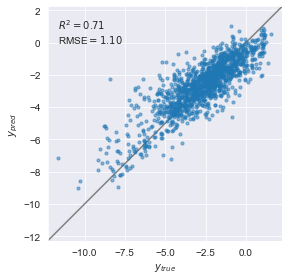

In [32]:
plot_true_vs_pred(y, y_oof)

In [29]:
estimator = clone(estimator).fit(X_selected, y)

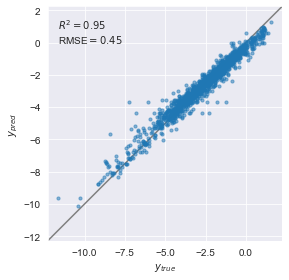

In [33]:
y_pred = estimator.predict(X_selected)
plot_true_vs_pred(y, y_pred)

In [34]:
# explainer = shap.LinearExplainer(model, X_selected)
explainer = shap.TreeExplainer(estimator, X_selected)
shap_values = pd.DataFrame(explainer.shap_values(X_selected), index=X_selected.index, columns=X_selected.columns)

 97%|=================== | 1252/1286 [00:31<00:00]       

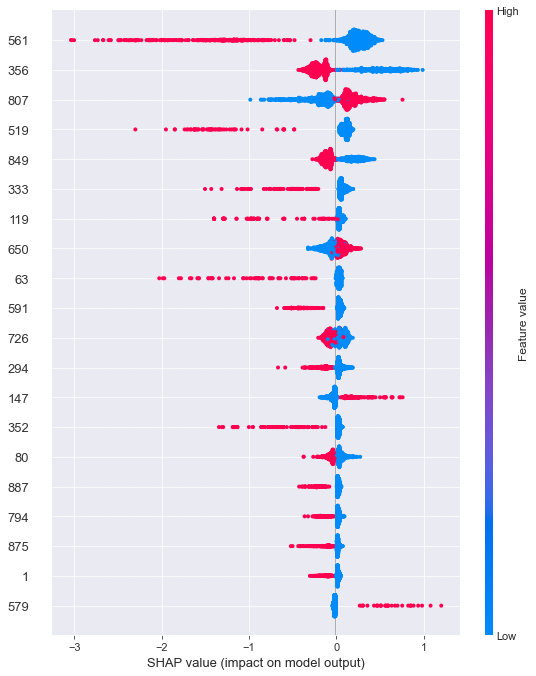

In [35]:
shap.summary_plot(shap_values.values, X_selected)

In [36]:
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[0], matplotlib=True)

In [37]:
shap_values.shape

(1286, 185)


$$
A_i = \sum_{n=1}^{N} \left( C_n \times \frac{1}{f_n} \times \frac{1}{x_n} \right)
$$

* $C_n$: 各フィンガープリントの寄与
* $f_n$: 分子中に含まれる各部分構造の数 ($n = 1, 2, \ldots, N$)
* $x_n$: 各部分構造に含まれる原子数

  0%|          | 0/5 [00:00<?, ?it/s]

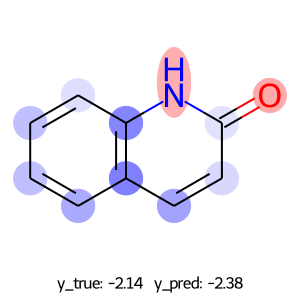

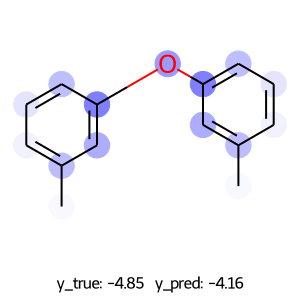

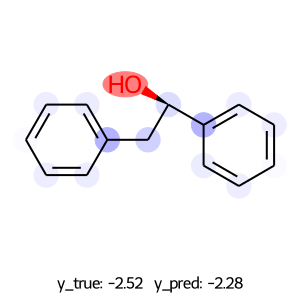

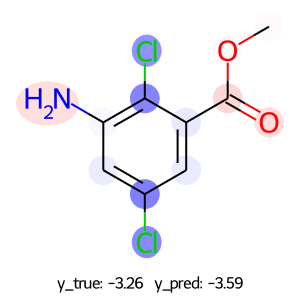

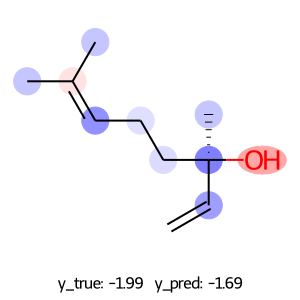

In [44]:
selected_bit_num = X_selected.columns.tolist()

# i = 1
# for i in trange(X_selected.shape[0]):    # samples
# for i in trange(10):    # samples
np.random.seed(334)
for i in tqdm(np.random.randint(0, X_selected.shape[0], 5)):

    bitinfo = bitinfos[i]
    # ratio_contribution = model.coef_[i] # C_n
    ratio_contributions:pd.Series = shap_values.iloc[i] # C_n
    mol = df_extracted['ROMol'][i]

    bit_list = list(set(bitinfo.keys()) & set(selected_bit_num))

    importance_atoms = np.zeros(mol.GetNumAtoms(), dtype=float)
    for _bit in bit_list:
        n_substructure = len(bitinfo[_bit])
        ratio_contribution = ratio_contributions[_bit]
        for i_atom, radius in bitinfo[_bit]:
            if radius == 0:
                n_atom_in_substructure = 1
                importance_atoms[i_atom] += ratio_contribution / n_atom_in_substructure / n_substructure
            else:
                atom_map = {}
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius=radius, rootedAtAtom=i_atom)
                submol = Chem.PathToSubmol(mol, env, atomMap=atom_map)

                n_atom_in_substructure = len(submol.GetAtoms())
                for j_atom in atom_map:
                    importance_atoms[j_atom] += ratio_contribution / n_atom_in_substructure

    # scaling
    importance_atoms_scaled = importance_atoms / abs(importance_atoms).max() * 0.5
    importance_atoms_scaled


    atom_colors = {i:(1, 1-importance_atoms_scaled[i], 1-importance_atoms_scaled[i]) if importance_atoms_scaled[i] > 0 else (1+importance_atoms_scaled[i], 1+importance_atoms_scaled[i], 1) for i in range(len(importance_atoms_scaled))}

    view = Draw.rdMolDraw2D.MolDraw2DSVG(300, 300)
    tm = Draw.rdMolDraw2D.PrepareMolForDrawing(mol)
    view.DrawMolecule(
        tm,
        highlightAtoms=atom_colors.keys(),
        highlightAtomColors=atom_colors,
        highlightBonds=[],
        highlightBondColors={},
        legend=f'y_true: {y[i]:.2f}  y_pred: {y_pred[i]:.2f}',
    )
    view.FinishDrawing()
    svg = view.GetDrawingText()
    with open('highlighted_sample.svg', 'w') as f:
        f.write(svg)
    display(SVG(svg))
np.random.seed()